# "Pawpularity" Prediction using machine learning with tabular metadata and images

A picture is worth a thousand words. But did you know a picture can save a thousand lives? Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. You might expect pets with attractive photos to generate more interest and be adopted faster. But what makes a good picture? With the help of data science, you may be able to accurately determine a pet photo’s appeal and even suggest improvements to give these rescue animals a higher chance of loving homes.

In this project, we are given both the tabular metadata storing binary feature variables and the pet images. Therefore, I would like to apply the regression methods taught in the first half of the course to tabular metadata, and computer vision-related mechine learning techniques will be used to interprete image data. 

The workflow of this project is depicted below. 

**1. Exploratory data analysis**
* Tabular metadata
* Image data

**2. Regression with tabular metadata**
* Feature engineering
* hyperparameter tuning
* Model training
* Result visualization

**3. Swin-Transformer with image data**
* Image data pre-processing
* Model construction
* Model training
* Result visualization

In this project, I conducted the model building and training individually for different data types. In the future, I may look for advanced methods to integrate these two data sources and maximize their prediction power.  


**Reference:**
* MATH 4995 tutorials from Mr. Zhicong Liang
* https://www.kaggle.com/alexteboul/tutorial-part-2-model-building-using-the-metadata
* https://www.kaggle.com/phalanx/train-swin-t-pytorch-lightning



## Package and dataset Installation

In [1]:
# install package by adding dataset
# you can find the torchsummary package in dataset: https://www.kaggle.com/truthr/torchsummary
# pytorch_grad_cam dataset in https://www.kaggle.com/math4995shao/gradcam135
# ttah 0.0.3: https://www.kaggle.com/dmitrykonovalov/ttach003
# and I also upload the python-box package in dataset: https://www.kaggle.com/zhicongliang/pythonbox
# and you can find timm in dataset: https://www.kaggle.com/kozodoi/timm-pytorch-image-models
# For loading the pretrained model, please include the dataset: https://www.kaggle.com/liucong12601/timmswin
# my pretrained weighted: https://www.kaggle.com/math4995shao/trained-swin-pawpularity


# then you can add these datasets to your notebook
!pip install ../input/torchsummary/torchsummary-1.5.1-py3-none-any.whl
!pip install ../input/pythonbox/python_box-5.4.1-py3-none-any.whl
!pip install ../input/timm-pytorch-image-models/pytorch-image-models-master
!pip install ../input/gradcam135/pytorch-grad-cam
!pip install ../input/ttach003/ttach-0.0.3-py3-none-any.whl

Processing /kaggle/input/torchsummary/torchsummary-1.5.1-py3-none-any.whl
torchsummary is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pythonbox/python_box-5.4.1-py3-none-any.whl
python-box is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/timm-pytorch-image-models/pytorch-image-models-master
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for timm: filename=timm-0.5.0-py3-none-any.whl size=416594 sha256=708c2e94241e7cf7e3c58f

## Library loading

In [2]:
#load in packages
import os
import pandas as pd
from glob import glob
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn')
import seaborn as sns
#sns.set_palette(sns.color_palette("Set2"))
import plotly.express as px

import sklearn

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, DaskLGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans

from PIL import Image
import os

np.random.seed(0)


import tqdm
from PIL import Image
import copy

from sklearn.model_selection import StratifiedKFold

from box import Box

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import timm



## Step 0: Configuration

In [3]:
config = {
    'root': '../input/petfinder-pawpularity-score/',
    'device': 'cuda', # 'cpu' for cpu, 'cuda' for gpu
    'n_splits': 5,
    'seed': 2021,
    'train_batchsize': 64,
    'val_batchsize': 64,
    'epoch': 20,
    'learning_rate': 1e-5,
    'logger_interval': 1,
    'model_name': 'swin_tiny_patch4_window7_224',
    'pretrain_path': '../input/timmswin/swin_tiny_patch4_window7_224.pth',
    'eta_min': 1e-4,
    'T_0': 20
}

# transform key to attribute. it will be easier for us to refer to these parameters later
config = Box(config)

# Exploratory data analysis

## 1. Tabular metadata
### Step 1: load the data
First thing you generally want to do when working with data is create variable names that are user friendly and relevant. Basically, you need to get the data stored in a way you can use it later on and is easy to understand.




In [33]:
df = pd.read_csv(os.path.join(config.root, 'train.csv'))
df['Id'] = df["Id"].apply(lambda x: os.path.join(config.root, "train", x + ".jpg")) # we transform the Id to its image path


### Step 2: Explore the metadata in train_df
The photo metadata refers to the .csv table data provided in this competition that has information about the subject focus, eyes, face, group etc. Let's explore this data first now that we've loaded the data into DataFrames. 

In [ ]:
#show the dimensions of the train metadata.
print('train_df dimensions: ', df.shape)
print('train_df column names: ', df.columns.values.tolist())

In [ ]:
#Lets see a the distribution of Pawpularity Scores
sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure()
sns.histplot(data=df, x='Pawpularity', bins=100)
plt.axvline(df['Pawpularity'].mean(), c='red', ls='-', lw=3, label='Mean Pawpularity')
plt.axvline(df['Pawpularity'].median(),c='blue',ls='-',lw=3, label='Median Pawpularity')
plt.title('Distribution of Pawpularity Scores', fontsize=20, fontweight='bold')
plt.legend()
plt.show()
plt.savefig(fname = './dist_pawpularity')

In [ ]:
#Calling .describe() lets you see the distribution in a numerical way
df[['Pawpularity']].describe()

In [ ]:
#visualize the distribution of Pawpularity scores across each feature variable
#get a the column names into a list
feature_variables = df.columns.values.tolist()

#for each of the feature variables, doesn't include Id and Pawpularity by using [1:-1]
#show a boxplot and distribution plot against pawpularity
for variable in feature_variables[1:-1]:
    fig, ax = plt.subplots(1,2)
    sns.boxplot(data=df, x=variable, y='Pawpularity', ax=ax[0])
    sns.histplot(df, x="Pawpularity", hue=variable, kde=True, ax=ax[1])
    plt.suptitle(variable, fontsize=20, fontweight='bold')
    fig.show()
    
plt.savefig(fname = './feature_pawpularity')

### Quick Analysis
You can't always tell just from looking at chart if you're going to be able to build a highly predictive model, but intuition is telling me that models are not going to be great based on these charts. The reason is that the distribution of pawpularity scores is very similar for each variable and class - in other words changing the features doesn't seem to influence the pawpularity scores that much. This might mean that a competition winning solution to this problem will require using the images and not the .csv metadata provided.

## 2. Image data
### Step 1: Customize image dataset
We need to constrcut a custom Dataset that will help us load the data and perform some basic transformations.

The most important functions of a custom Dataset is `__len__` and `__getitem__`.

The `__len__` function will return the number of elements in this dataset, while `__getitem__` will return an image-label pair that can be accepted by pytorch given an index.

In [27]:
# define Custom Dataset with pytorch
class PetfinderDataset(Dataset):

    def __init__(self, df, image_size=224, transform=None):
        self._X = df["Id"].values
        self._y = None
        if "Pawpularity" in df.keys():
            self._y = df["Pawpularity"].values
        if not transform:
            # we resize all the image to the same size
            self._transform = T.Compose([
                T.Resize([image_size, image_size]),
                T.ToTensor(), # transform the PIL image type to torch.tensor
            ])
        else:
            self._transform = transform

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
        # given the index(path), read the raw image, and then transform it
        # image = read_image(image_path)  # this require the latest torchvision version
        image = Image.open(image_path)
        image = self._transform(image)
        # if we have label, then we return the image-label pair (for training)
        # if not, we directly return the image (for testing)
        if self._y is not None:
            label = self._y[idx]
            return image, label
        return image

In [28]:
train_val_set = PetfinderDataset(df)

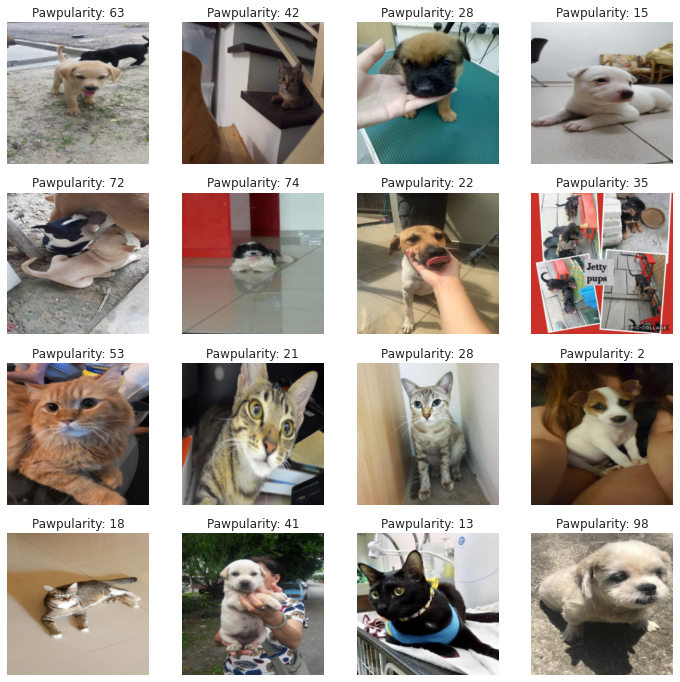

In [29]:
# we show some images here
plt.figure(figsize=(12, 12))
for idx  in range(16):
    image, label = train_val_set.__getitem__(idx)
    plt.subplot(4, 4, idx+1)
    plt.imshow(image.permute(1, 2, 0));
    plt.axis('off')
    plt.title('Pawpularity: {}'.format(label))

### Step 2: build a function that returns pet pictures based on given pawpularity scores

In [30]:
def pawpularity_pics(df, num_images, desired_pawpularity, random_state):
    '''The pawpularity_pics() function accepts 4 parameters: df is a dataframe, 
    num_images is the number of images you want displayed, desired_pawpularity 
    is the pawpularity score of pics you want to see, and random state ensures reproducibility.'''
    #how many images to display
    num_images = num_images
    #set the rample state for the sampling for reproducibility
    random_state = random_state
    
    #filter the train_df on the desired_pawpularity and use .sample() to get a sample
    random_sample = df[df["Pawpularity"] == desired_pawpularity].sample(num_images, random_state=random_state).reset_index(drop=True)
    
    #The for loop goes as many loops as specified by the num_images
    for x in range(num_images):
        #start from the id in the dataframe
        image_path = random_sample.iloc[x]['Id']
        #image_path_stem = random_sample.iloc[x]['Id']
        #root = '../input/petfinder-pawpularity-score/train/'
        #extension = '.jpg'
        #image_path = root + str(image_path_stem) + extension
         
        #get the pawpularity to confirm it worked
        pawpularity_by_id = random_sample.iloc[x]['Pawpularity']
    
        #use plt.imread() to read in the image file
        image_array = plt.imread(image_path)
        #make a subplot space that is 1 down and num_images across
        plt.subplot(1, num_images, x+1)
        #title is the pawpularity score from the id
        title = pawpularity_by_id
        plt.title(title) 
        #turn off gridlines
        plt.axis('off')
        #then plt.imshow() can display it for you
        plt.imshow(image_array)
    plt.show()
    plt.close()

### Example: Pawpularity 10

In [ ]:
num_images = 5
desired_pawpularity = 10
random_state = 1
pawpularity_pics(df, num_images, desired_pawpularity, random_state)
plt.savefig(fname = "./example_pawpularity_10")

### Example: Pawpularity 100

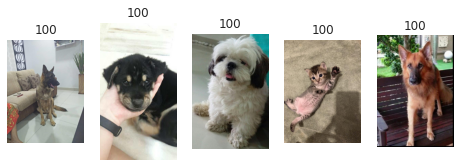

<Figure size 576x396 with 0 Axes>

In [32]:
num_images = 5
desired_pawpularity = 100
random_state = 1
pawpularity_pics(df, num_images, desired_pawpularity, random_state)
plt.savefig(fname = "./example_pawpularity_100")

# Regression with tabular metadata
## 1. Feature engineering
### Step 1: Add size and shape of images to the data

Add normalized size and shape of images to the data

In [34]:
def size_and_shape(row):
    img = Image.open(row['Id'])
    return pd.Series([img.size[0], img.size[1], os.path.getsize(row['Id'])])

In [35]:
scale = MinMaxScaler()

df[['width', 'height', 'size']] = pd.DataFrame(scale.fit_transform(df.apply(size_and_shape, axis=1).values))


### Step 2: Add Clusters to the data

In [36]:
X = df.drop(['Id', 'Pawpularity'], axis=1)
y = df['Pawpularity']

In [37]:
k = KMeans(8, random_state=0)

k.fit(X)

X['cluster'] = k.predict(X)


### Step 3: Add Principal Component Analysis features to the data

In [38]:
p = PCA()

p.fit(X)

X = X.join(pd.DataFrame(p.transform(X)))


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 2. Hyperparameter tuning
In this project, I chose to use Random Forest and light GBM, and then combine them with voting regression. The reason why I chose these workflow is that I want to try such ensemble method to leverage the combination of "weak" learners and they can report feature importance for better interpretation. 

### Step 1: define the evaluation function

In [42]:
def eval_model(model):
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)

    return mean_squared_error(y_test, preds, squared=False)

### Step 2: Hyperparameter tuning with grid search

In [ ]:
### Random Forest
rf_baseline = RandomForestRegressor(random_state=0)



rf_tuned_parameters = [{'n_estimators': [50,75,100], 
                    'max_depth': [4,5,6], 
                    'max_features': [6,9,12]}]

rf_clf = GridSearchCV(rf_baseline, rf_tuned_parameters, cv=5, scoring='neg_root_mean_squared_error')
rf_clf.fit(X, y)

In [ ]:
rf_clf.best_score_

In [ ]:
rf_clf.best_params_

In [ ]:
### light GBM
light_baseline = LGBMRegressor(random_state=0)

light_tuned_parameters = [{'num_leaves': [3,4,5], 
                    'subsample_for_bin': [20,30,40], 
                    'min_split_gain': [0.05,0.1,0.2], 
                    'min_child_samples': [20,25,30]}]

light_clf = GridSearchCV(light_baseline, light_tuned_parameters, cv=5, scoring='neg_root_mean_squared_error')
light_clf.fit(X, y)

In [ ]:
light_clf.best_score_

In [ ]:
light_clf.best_params_

## 3. Model training

In [43]:
rf = RandomForestRegressor(random_state=0, 
                              n_estimators=50,
                              max_depth=5, 
                              max_features=9)

light = LGBMRegressor(random_state=0,
                      num_leaves=3,
                      subsample_for_bin=30, 
                      min_split_gain=0.05,
                      min_child_samples=25)

models = {'rf': rf, 'light': light}

for model in models:
    print(model, 'RMSE:', eval_model(models[model]))

rf RMSE: 20.787042570665005
light RMSE: 20.724622819398444


In [44]:
models_vote = [(model, models[model]) for model in models]

vote = VotingRegressor(estimators=models_vote)

vote.fit(X_train, y_train)

eval_model(vote)

20.74649381702782

## 4. Result visualization
### Step 1: Feature importance

In [ ]:
### Random Forest

feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

In [ ]:
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Random Forest: Feature Importance", size = 40)
ax.set_yticklabels(feature_scores.index, size = 30)
ax.set_xlabel("Feature importance score", size = 20)
ax.set_ylabel("Features", size = 20)
plt.show()
plt.savefig(fname = './rf_importance')

In [ ]:

feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

In [ ]:
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Light GBM: Feature Importance", size = 40)
ax.set_yticklabels(feature_scores.index, size = 30)
ax.set_xlabel("Feature importance score", size = 20)
ax.set_ylabel("Features", size = 20)
plt.show()
plt.savefig(fname = './light_importance')

### Step 2: Comparison between predictions and true values in test data

In [45]:
#let's see what our predictions look like vs the actual 
def ActualvPredictionsGraph(y_test,y_pred,title):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.figure(figsize=(12,3))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.xlabel('Index ')
    plt.ylabel('Pawpularity ')
    plt.title(title,fontdict = {'fontsize' : 15})
    plt.legend(handles = [mpatches.Patch(color='red', label='prediction'),mpatches.Patch(color='blue', label='actual')])
    plt.show()
    return



In [ ]:
### Random Fore
rf_pred = rf.predict(X_test)

#plot it
ActualvPredictionsGraph(y_test, rf_pred, "Random Forest: All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(rf_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()
plt.savefig('./rf_predict_comparison')

In [ ]:
### Random Fore
light_pred = light.predict(X_test)

#plot it
ActualvPredictionsGraph(y_test, light_pred, "Light GBM: All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(light_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()
plt.savefig('./light_predict_comparison')

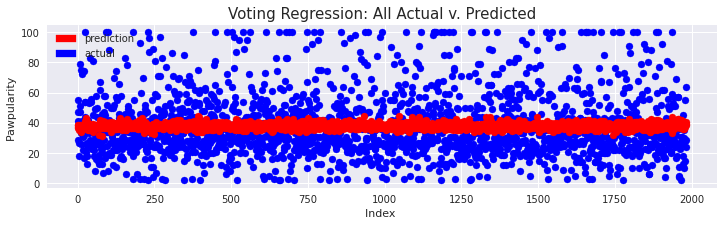

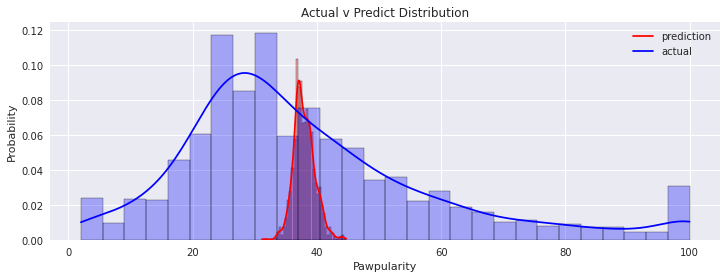

<Figure size 576x396 with 0 Axes>

In [47]:
### Voting regression
vote_pred = vote.predict(X_test)

#plot it
ActualvPredictionsGraph(y_test, vote_pred, "Voting Regression: All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(vote_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()
plt.savefig('./voting_predict_comparison')

# Swin-Transformer with image data

In [ ]:
df = pd.read_csv(os.path.join(config.root, 'train.csv'))
df['Id'] = df["Id"].apply(lambda x: os.path.join(config.root, "train", x + ".jpg")) # we transform the Id to its image path

## 1. Image data pre-processing
### Step 1: Standard Augmentation and MixUp
we would like to do some random transformation to our training data such that our model can be more rubost against different patterns in out-of-sample data.

In [ ]:
train_transform = T.Compose([
        T.Resize([224, 224]), # crop the image size to 3*224*224
        T.RandomHorizontalFlip(), # random flip the image horizontally
        T.RandomVerticalFlip(), # random flip the image vertically
        T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random affine transformation of the image keeping center invariant.
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # randomly changes the brightness, saturation, and other properties of an image
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# in validation set, we only convert our data to torch.float and do a normalization
val_transform = T.Compose([
        T.Resize([224, 224]),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
# mixing up the training data within a batch to further create "diversity" to improve the generalization ability of the model.
def mixup(x, y, alpha=1):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."
    
    lam = np.random.beta(alpha, alpha)
#     for the shape of lam, run the following two lines
#     import seaborn as sns
#     sns.distplot(np.random.beta(0.5,0.5, 1000), bins=100)
    rand_index = torch.randperm(x.size()[0]) # random permutation of images in the batch x
    mixed_x = lam * x + (1-lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

## 2. Model construction

In [5]:
class Model(nn.Module):
    def __init__(self, name):
        super(Model, self).__init__()
        self.backbone = timm.create_model(name, 
                                          pretrained=True,   # We can utilize trained model as input dataset
                                          #pretrained=False, # it would be very easy to set it to true
                                                            # but in kaggle we could not use internet to download it
                                          num_classes=0, 
                                          in_chans=3)
        
        state_dict = torch.load(config.pretrain_path, map_location=config.device)['model']
        del state_dict['head.weight'] # in the model, we don't have these two parameters actually
        del state_dict['head.bias']
        
        self.backbone.load_state_dict(state_dict)
        num_features = self.backbone.num_features
        self.fc = nn.Sequential(nn.Dropout(0.5),
                                nn.Linear(num_features, 1)
                               )
        
    def forward(self, x):
        f = self.backbone(x)
        out = self.fc(f)
        return out

In [ ]:
import torchsummary
# here we show the summary of the model
model = Model(config.model_name)
torchsummary.summary(model, (3,224,224), device='cpu')

## 3. Model training

In [ ]:
### RMSE matric for validation set
def test(model, test_loader):
    model.eval() # turn model into evaluation mode
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(config.device), target.float().to(config.device)/100.
            output = model(data)
            test_loss += F.mse_loss(output.sigmoid().view(-1), 
                                    target.view(-1), reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)
    return np.sqrt(test_loss) # RMSE 

In [ ]:
# we split the dataset into for cross-validation
# here we treat the label "Pawpularity" as categorical data, and use the StratifiedKfol Function
# actually it is numerical data
skf = StratifiedKFold(
    n_splits=config.n_splits, shuffle=True, random_state=config.seed
)

In [ ]:
# we keep record of the training in each fold
train_losses_fold = []
val_losses_fold = []
best_model_fold = []
learning_rate_fold = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df["Id"], df["Pawpularity"])):
    
    print('================================ CV fold {} ================================'.format(fold))
    
    train_df = df.loc[train_idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)
    
    # we would like to do some random transformation to our training data such that
    # our model can be more rubost against different patterns in out-of-sample data
    train_transform = T.Compose([
        T.Resize([224, 224]), # crop the image size to 3*224*224
        T.RandomHorizontalFlip(), # random flip the image horizontally
        T.RandomVerticalFlip(), # random flip the image vertically
        T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random affine transformation of the image keeping center invariant.
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # randomly changes the brightness, saturation, and other properties of an image
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # in validation set, we only convert our data to torch.float and do a normalization
    val_transform = T.Compose([
        T.Resize([224, 224]),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_set = PetfinderDataset(train_df, transform=train_transform)
    val_set = PetfinderDataset(val_df, transform=val_transform)
    
    # then we define the dataloader for training and validation
    # it tells the machine how to sample from our training/validation set
    train_loader = DataLoader(train_set, batch_size=config.train_batchsize, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_set, batch_size=config.val_batchsize, num_workers=4)
    
    model = Model(config.model_name).to(config.device) # use GPU to accelerate the training. Kaggle gives us 30h every week.
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
    # we decay the learning rate by factor gamma=0.1 when we reach each milestone epoch
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, eta_min=config.eta_min, T_0=config.T_0)
    # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
    criterion = nn.BCEWithLogitsLoss()
    
    train_losses = []
    val_losses = []
    learning_rates = []
    
    best_val_loss = np.inf
    best_model = None
    
    for epoch in range(config.epoch):
        print('\t=================== Epoch {} ==================='.format(epoch))
        
        model.train() # turn model into training mode
        batch_train_loss = []
        
        # iterate each batch to update the model
        for batch_idx, (data, target) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(config.device), target.float().to(config.device) / 100. # we transform the label to [0,1]
            optimizer.zero_grad() # very important. without this step, grad will accumulate
            
            if torch.rand(1)[0] < 0.5:
                mix_images, target_a, target_b, lam = mixup(data, target, alpha=0.5)
                output = model(mix_images)
                loss = lam * criterion(output.view(-1), target_a.view(-1)) + (1-lam) * criterion(output.view(-1), target_b)
            else:
                output = model(data)
                loss = criterion(output.view(-1), target.view(-1))
                
            loss.backward()
            optimizer.step() # update the model by the gradient
            
            batch_train_loss.append(loss.item())
        
        if epoch % config.logger_interval == 0:
            train_loss = np.sum(batch_train_loss)/len(train_loader) # BCEWithLogitsLoss loss
            val_loss = test(model, val_loader) * 100 # RMSE loss
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            print('\t\t train loss: {:.4f}'.format(train_loss))
            print('\t\t val loss: {:.4f} -- best loss: {:.4f}'.format(val_loss, best_val_loss))
            
            # if we get a lower validation loss, then we record the model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(model)

            learning_rates.append(optimizer.param_groups[0]['lr'])
                  
        scheduler.step()
    
    train_losses_fold.append(train_losses)
    val_losses_fold.append(val_losses)
    learning_rate_fold.append(learning_rates)
    best_model_fold.append(best_model)
             

# Save the trained model to improve the efficiency

In [ ]:
## save the models

for fold, model in enumerate(best_model_fold):
    torch.save(model.state_dict(), 'swin_transformer_fold_{}.h5'.format(fold))

# Load the pretrained model for efficient visualization and prediction

In [6]:
# my pretrained weighted: https://www.kaggle.com/math4995shao/trained-swin-pawpularity
## load the models
best_model_fold = []
for fold in range(5):
    model = Model(config.model_name).to(config.device)
    model.load_state_dict(torch.load('../input/trained-swin-pawpularity/trained_swin/swin_transformer_fold_{}.h5'.format(fold), map_location=torch.device(config.device)))
    best_model_fold.append(model)

## 4. Result visualization
### Step 1: Training & validation loss

In [ ]:
train_losses = np.array(train_losses_fold)
val_losses = np.array(val_losses_fold)

In [ ]:
index = range(0, config.epoch, config.logger_interval)
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(index, train_losses.mean(axis=0), label='Training Loss')
plt.legend(fontsize=15)
plt.xlabel('Epoch', fontsize=15)

plt.subplot(122)
plt.plot(index, val_losses.mean(axis=0), label='Validation Loss')
plt.legend(fontsize=15)
plt.xlabel('Epoch', fontsize=15)

plt.savefig('./swin_transformer_training_validation_loss')

### Step 2: Learning rate

In [ ]:
learning_rate = np.array(learning_rate_fold)
index = range(0, config.epoch, config.logger_interval)
fig = plt.figure(figsize=(8,6))
plt.plot(index, learning_rate[0,:], label='learning rate')
plt.legend(fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Learning rate', fontsize=15)

plt.savefig('./swin_transformer_learning_rate')

### Step 3: Grad-Cam

In [ ]:
# gradcam reshape_transform for vit
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # like in CNNs.
    result = result.permute(0, 3, 1, 2)
    return result

In [ ]:
## prepare the images we would like to visualize

from copy import deepcopy

norm_transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


org_images = [] # store the original image inside the range [0,1]
labels = []     # store the label
images = []     # store the normalized images as the input for the model
for idx in range(16):
    image, label = train_val_set.__getitem__(idx+1000)
    images.append(norm_transform(deepcopy(image)).unsqueeze(0).float().to(config.device))
    org_images.append(image.unsqueeze(0))
    labels.append(label)
    
images = torch.cat(images)
org_images = torch.cat(org_images)
labels = torch.tensor(labels)

In [ ]:
# load the best well-trained model (fold2) and do the prediction
model = best_model_fold[2]
model = model.eval().to(config.device)
logits = model(images)
preds = logits.sigmoid().detach().cpu().squeeze(1).numpy() * 100
labels = labels.cpu().numpy()

In [ ]:
## use gradcam for visualization
cam = GradCAMPlusPlus(
            model=model,
            target_layers = [model.backbone.layers[-1].blocks[-1].norm1], 
            #target_layer=model.backbone.layers[-1].blocks[-1].norm1, 
            use_cuda=config.device,
            reshape_transform=reshape_transform)

grayscale_cams = cam(input_tensor=images, target_category=None, eigen_smooth=True)
org_images = org_images.numpy().transpose(0, 2, 3, 1)

In [ ]:
plt.figure(figsize=(12, 12))
for it, (image, grayscale_cam, pred, label) in enumerate(zip(org_images, grayscale_cams, preds, labels)):
    plt.subplot(4, 4, it + 1)
    visualization = show_cam_on_image(image, grayscale_cam)
    plt.imshow(visualization)
    plt.title('pred: {:.1f} label: {}'.format(pred, label))
    plt.axis('off')
    
plt.savefig('./example_gradcam')

### Step 4: Comparison between predictions and true values in training" data

In [7]:
def ActualvPredictionsGraph(y_test,y_pred,title):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.figure(figsize=(12,3))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.xlabel('Index ')
    plt.ylabel('Pawpularity ')
    plt.title(title,fontdict = {'fontsize' : 15})
    plt.legend(handles = [mpatches.Patch(color='red', label='prediction'),mpatches.Patch(color='blue', label='actual')])
    plt.show()
    return


In [10]:
df_val = df.drop(['Pawpularity'], axis=1)

df_val = df_val[:300]
val_label = df['Pawpularity'][:300]
val_id = df_val.index

val_transform = T.Compose([
    T.Resize([224, 224]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_set = PetfinderDataset(df_val, transform=val_transform)
val_loader = DataLoader(val_set, batch_size=config.val_batchsize, num_workers=4)

# get the testing prediction
val_pred = np.zeros((df_val.shape[0],1))

for model in best_model_fold:
    for batch_idx, data in enumerate(val_loader):
        data = data.to(config.device)
        output = model(data)
        if batch_idx == 0:
            preds = output.detach().sigmoid().to('cpu').numpy()* 100
        else:
            preds = np.vstack((preds, output.sigmoid().detach().to('cpu').numpy()* 100))

    val_pred += preds

# take the average over folds
val_pred = val_pred / len(best_model_fold)

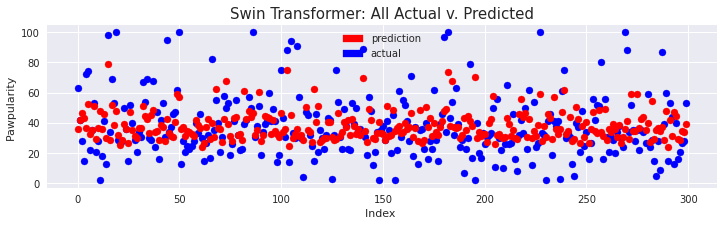

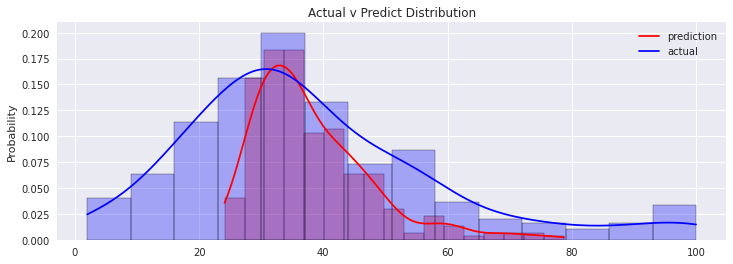

<Figure size 576x396 with 0 Axes>

In [26]:
ActualvPredictionsGraph(val_label, val_pred, "Swin Transformer: All Actual v. Predicted")

val_pred = val_pred.reshape(-1)
val_label  = np.array(val_label)

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(val_pred,color='red',alpha=0.3,stat='probability', kde=True)
sns.histplot(np.array(val_label),color='blue',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()
plt.savefig('./swin_predict_comparison')

# Submission

In [ ]:
df_test = pd.read_csv(os.path.join(config.root, 'test.csv'))
test_id = df_test.index
df_test['Id'] = df_test["Id"].apply(lambda x: os.path.join(config.root, "test", x + ".jpg")) # we transform the Id to its image path

test_transform = T.Compose([
    T.Resize([224, 224]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_set = PetfinderDataset(df_test, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=config.val_batchsize, num_workers=4)

# get the testing prediction
test_pred = np.zeros((df_test.shape[0],1))

for model in best_model_fold:
    for batch_idx, data in enumerate(test_loader):
        data = data.to(config.device)
        output = model(data)
        if batch_idx == 0:
            preds = output.detach().sigmoid().to('cpu').numpy()* 100
        else:
            preds = np.vstack((preds, output.sigmoid().detach().to('cpu').numpy()* 100))

    test_pred += preds

# take the average over folds
test_pred = test_pred / len(best_model_fold)

submission = pd.read_csv(os.path.join(config.root, 'test.csv'))[['Id']]
submission['Pawpularity'] = test_pred
submission

In [ ]:
submission.to_csv('submission.csv', index=False)